## Transfer Learning with TensorFlow, scaling up (🍔👀Food Vision mini)

We've seen the power of transfer learning feature extraction and fine_tuning, now it's time to scale up to all of the classes in food101 (101 totl classes of food).

Our goual is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper [here](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf).

Our baseline to beat is 50.76% accuracy across 101 classes

In [1]:
# Check connection
!nvidia-smi

Sat Jan 27 21:58:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

Download the helper functions

In [2]:
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py

--2024-01-27 21:58:44--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13380 (13K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  13.07K  --.-KB/s    in 0s      

2024-01-27 21:58:44 (122 MB/s) - ‘helper.py’ saved [13380/13380]



In [3]:
# Import series of helper functions for our notebook
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 FoodClasses: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the [image_data_modification](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) notebook.

In [4]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-01-27 21:58:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  20.1MB/s    in 79s     

2024-01-27 22:00:07 (19.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 dire

In [6]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we´re going to take:
* Create a `ModelCheckpoint` callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # To save time, if False it'll take alot of time to sve the whole model
                                                         monitor="val_accuracy",
                                                         save_best_only=True) # Saves the best weights for val_accuracy

In [8]:
# Create data augmentation layer (If we put it into the model the augmentation will happen o the GPU wich is faster)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) # Can be skipped when using EfficieNet models (built in)
], name="data_augmentation")

In [9]:
# Setup the base model and freeze it layers (this will extrac features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False;

# Setup model arcitecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the bas model in inference mode so weights wich needs to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="blobal_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # Output neurons = 101(classes)
# Create the model
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


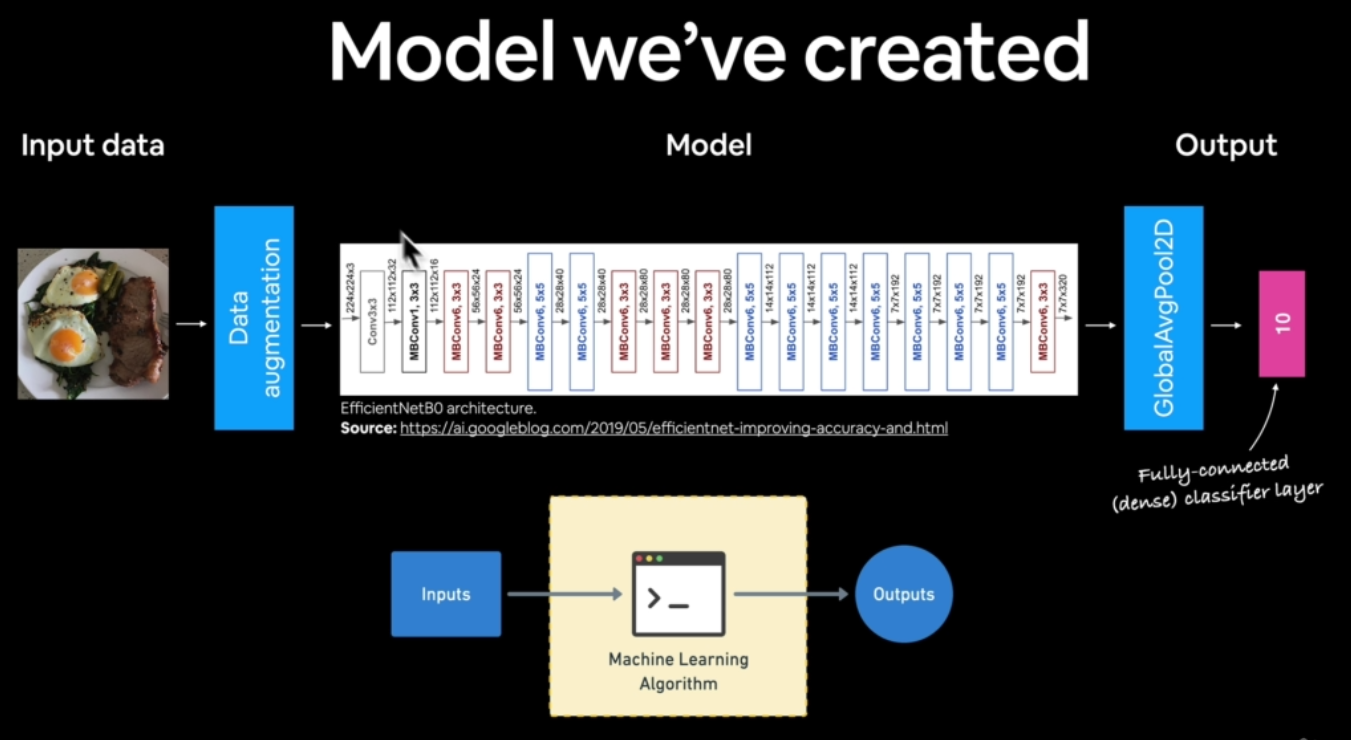

In [10]:
# Get a summmary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 blobal_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs for quick exp
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 145s 573ms/step - loss: 3.3667 - accuracy: 0.2766 - val_loss: 2.6416 - val_accuracy: 0.3954
Epoch 2/5
237/237 [==============================] - 88s 371ms/step - loss: 2.1931 - accuracy: 0.4991 - val_loss: 2.1502 - val_accuracy: 0.4682
Epoch 3/5
237/237 [==============================] - 86s 359ms/step - loss: 1.8252 - accuracy: 0.5633 - val_loss: 1.9785 - val_accuracy: 0.4976
Epoch 4/5
237/237 [==============================] - 73s 307ms/step - loss: 1.6011 - accuracy: 0.6091 - val_loss: 1.9079 - val_accuracy: 0.5106
Epoch 5/5
237/237 [==============================] - 65s 273ms/step - loss: 1.4460 - accuracy: 0.6441 - val_loss: 1.8545 - val_accuracy: 0.5204


In [12]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 47s 60ms/step - loss: 1.5898 - accuracy: 0.5817


[1.5898391008377075, 0.5817029476165771]

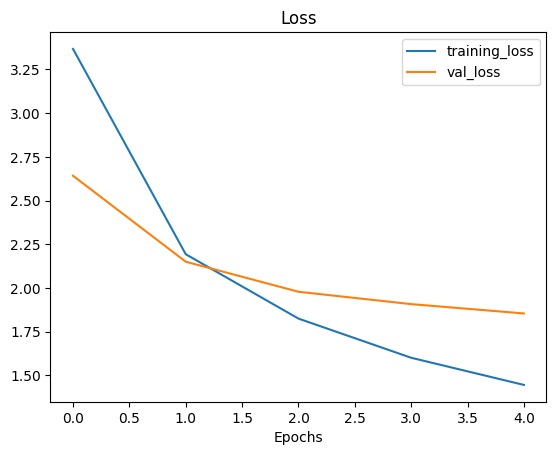

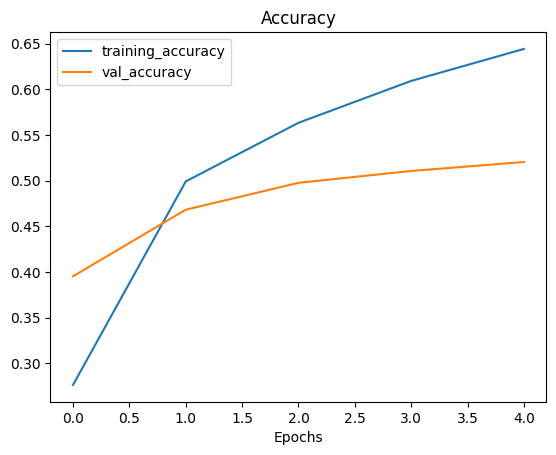

In [13]:
# Plot loss curves, overfitting :P
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [15]:
# Recompile model with lower learning rate (best practice to lower lr when unfreeze layers)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
blobal_avg_pool_layer True
output_layer True


In [17]:
# Check wich layres are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [18]:
# Fine tune for 5 more epochs were we left off last traning
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_tune_all_classes_ten_percent = model.fit(train_data_all_10_percent,
                                                           epochs=fine_tune_epochs,
                                                           validation_data=test_data,
                                                           validation_steps=int(0.15 * len(test_data)),
                                                           initial_epoch=history_all_classes_10_percent.epoch[-1],
                                                           callbacks=[create_tensorboard_callback(dir_name="transfer_lerning", # Not necessary
                                                                                                  experiment_name="10_percent_all_classes_last_five_layers_fine_tuned")])

Saving TensorBoard log files to: transfer_lerning/10_percent_all_classes_last_five_layers_fine_tuned/20240127-220852
Epoch 5/10
237/237 [==============================] - 68s 256ms/step - loss: 1.4956 - accuracy: 0.5972 - val_loss: 1.9823 - val_accuracy: 0.4979
Epoch 6/10
237/237 [==============================] - 58s 246ms/step - loss: 1.0623 - accuracy: 0.7075 - val_loss: 1.9015 - val_accuracy: 0.5154
Epoch 7/10
237/237 [==============================] - 57s 238ms/step - loss: 0.8145 - accuracy: 0.7737 - val_loss: 2.0085 - val_accuracy: 0.5053
Epoch 8/10
237/237 [==============================] - 50s 209ms/step - loss: 0.6469 - accuracy: 0.8133 - val_loss: 2.1284 - val_accuracy: 0.4928
Epoch 9/10
237/237 [==============================] - 49s 207ms/step - loss: 0.5155 - accuracy: 0.8481 - val_loss: 2.3319 - val_accuracy: 0.4603
Epoch 10/10
237/237 [==============================] - 46s 195ms/step - loss: 0.4181 - accuracy: 0.8751 - val_loss: 2.1713 - val_accuracy: 0.5188


In [19]:
# Evaluate the fine tuned model
results_fine_tune_10_percent_all_classes = model.evaluate(test_data)
results_fine_tune_10_percent_all_classes

790/790 [==============================] - 47s 59ms/step - loss: 1.8840 - accuracy: 0.5735


[1.8839865922927856, 0.5735049247741699]

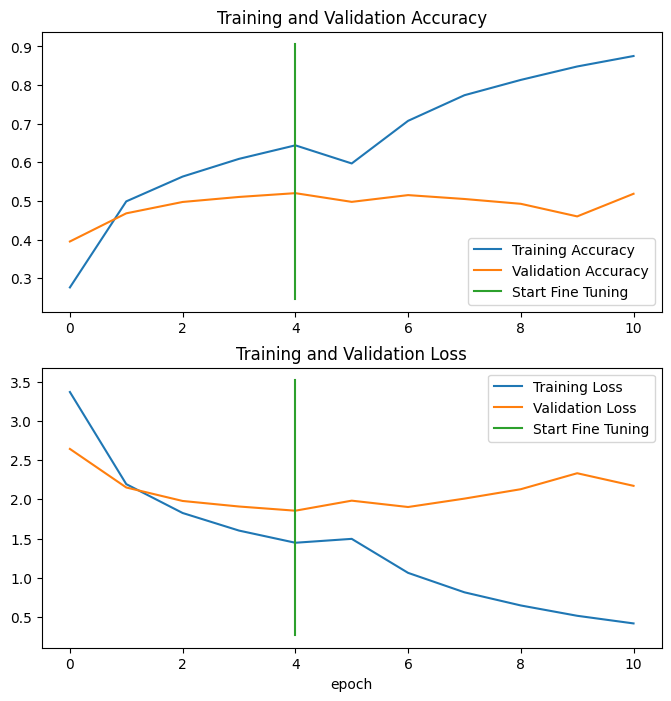

In [20]:
# Check the loss curves, model is overfittning on the training data
compare_historys(history_all_classes_10_percent,
                 history_fine_tune_all_classes_ten_percent,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [21]:
# save our fine-tuning model (to google drive)
model.save("drive/MyDrive/TensorFlow/101_foof_classes_10_percent_saved_model")

In [22]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/TensorFlow/101_foof_classes_10_percent_saved_model")

In [23]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 49s 60ms/step - loss: 1.8840 - accuracy: 0.5735


[1.8839865922927856, 0.5735049247741699]

In [24]:
# The results from our loaded model (above) should be very similar to the results below
results_fine_tune_10_percent_all_classes

[1.8839865922927856, 0.5735049247741699]

## Evaluating the performance of the model across different classes

Let's make predictions, visualize them and later find out wich predictions were the "most" wrong.

In [25]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbose to see how long is left

790/790 [==============================] - 45s 55ms/step


In [26]:
len(test_data)

790

In [27]:
# How many predictions are there?
len(preds_probs)

25250

In [28]:
# Whats the shape of our predictions?
preds_probs.shape

(25250, 101)

In [29]:
# Let's see what the 10 first predictions look like
preds_probs[:10]

array([[3.60106751e-02, 1.21672565e-05, 8.10908854e-01, ...,
        1.67272972e-07, 1.06221953e-04, 5.06083132e-04],
       [9.66030061e-01, 1.77011583e-09, 2.08751927e-03, ...,
        1.34584683e-04, 2.68933658e-08, 2.71130233e-07],
       [4.40207869e-01, 4.73157652e-02, 4.07060683e-02, ...,
        4.38571005e-05, 4.09064596e-05, 2.41633374e-04],
       ...,
       [3.52040455e-02, 1.54390307e-07, 6.14961828e-05, ...,
        3.26623721e-03, 7.21022443e-05, 1.11390837e-05],
       [1.16113564e-02, 2.95411664e-05, 9.43321705e-01, ...,
        4.84508091e-05, 1.10585825e-06, 6.47883280e-06],
       [3.58532071e-01, 4.48606521e-08, 9.10508796e-04, ...,
        1.50651089e-04, 2.29756409e-08, 6.02414402e-05]], dtype=float32)

In [30]:
# What does the first prediction probability array looks like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.60106751e-02, 1.21672565e-05, 8.10908854e-01, 5.34296551e-10,
        8.04827209e-08, 4.33584972e-08, 3.65647466e-05, 4.69206256e-08,
        1.55040831e-03, 7.87454510e-08, 5.61282889e-07, 3.11204388e-07,
        1.81447285e-05, 6.20690654e-09, 7.67020720e-06, 1.92669526e-04,
        7.90570141e-07, 1.74985165e-04, 1.04952557e-02, 8.91024456e-07,
        1.10583002e-04, 2.87087289e-07, 2.10185644e-05, 5.34843421e-05,
        3.37371533e-03, 4.25257713e-05, 4.17430419e-04, 3.74436877e-06,
        1.91484566e-03, 9.31838222e-05, 1.40332572e-08, 6.28986105e-04,
        5.42964481e-05, 1.22627837e-08, 1.46102422e-04, 4.54988310e-07,
        4.15158297e-07, 3.22636588e-05, 1.31254096e-03, 1.21520188e-05,
        5.35771233e-06, 2.94785220e-02, 7.23292214e-06, 1.01771047e-05,
        5.33871798e-06, 4.94779215e-06, 9.54212737e-05, 3.60317281e-05,
        7.92536952e-08, 1.98431706e-04, 1.19173637e-05, 1.72685120e-08,
        7.43701532e-02, 1.14067385e-04, 1.70046633e-06, 1.600121

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [31]:
# We get one pred probability per class( in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.60106751e-02 1.21672565e-05 8.10908854e-01 5.34296551e-10
 8.04827209e-08 4.33584972e-08 3.65647466e-05 4.69206256e-08
 1.55040831e-03 7.87454510e-08 5.61282889e-07 3.11204388e-07
 1.81447285e-05 6.20690654e-09 7.67020720e-06 1.92669526e-04
 7.90570141e-07 1.74985165e-04 1.04952557e-02 8.91024456e-07
 1.10583002e-04 2.87087289e-07 2.10185644e-05 5.34843421e-05
 3.37371533e-03 4.25257713e-05 4.17430419e-04 3.74436877e-06
 1.91484566e-03 9.31838222e-05 1.40332572e-08 6.28986105e-04
 5.42964481e-05 1.22627837e-08 1.46102422e-04 4.54988310e-07
 4.15158297e-07 3.22636588e-05 1.31254096e-03 1.21520188e-05
 5.35771233e-06 2.94785220e-02 7.23292214e-06 1.01771047e-05
 5.33871798e-06 4.94779215e-06 9.54212737e-05 3.60317281e-05
 7.92536952e-08 1.98431706e-04 1.19173637e-05 1.72685120e-08
 7.43701532e-02 1.14067385e-04 1.70046633e-06 1.60012169e-05
 3.25701811e-04 4.64450495e-05 1.87440761e-

In [32]:
test_data.class_names[0]

'apple_pie'

In [33]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 2,  0,  0, 38,  8, 78, 29, 46,  2, 41])

In [34]:
# How many pred clases do we have?
len(pred_classes)

25250

Now we'vegot a predictions array of all of our models predictions, to evaluate them, we need to compare them to original test dataset


In [35]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently test labels look llike-. [0, 0, 0, 1, ..... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # Look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [36]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same orde as our test labels array is to find the accuracy score

In [37]:
results_fine_tune_10_percent_all_classes

[1.8839865922927856, 0.5735049247741699]

In [38]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

sklearn_accuracy

0.5735049504950495

In [39]:
# Does this metric come close to our model's evaluate results?
import numpy as np
np.isclose(results_fine_tune_10_percent_all_classes[1], sklearn_accuracy)

True

## Let's get visual: making a configuration matrix


## Let's get visual: making a confusion matrix

In [40]:
# Import helper function
from helper import make_confusion_matrix

In [41]:
# Get  list of class names
class_names= test_data.class_names
# Print out 10
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [42]:
from helper import make_confusion_matrix_with_x_axis_labels_rotated

In [43]:
make_confusion_matrix_with_x_axis_labels_rotated(y_true=y_labels,
                                                y_pred=pred_classes,
                                                classes=class_names,
                                                figsize=(100, 100),
                                                text_size=20,
                                                savefig=True)

![2024-01-25 (6).png](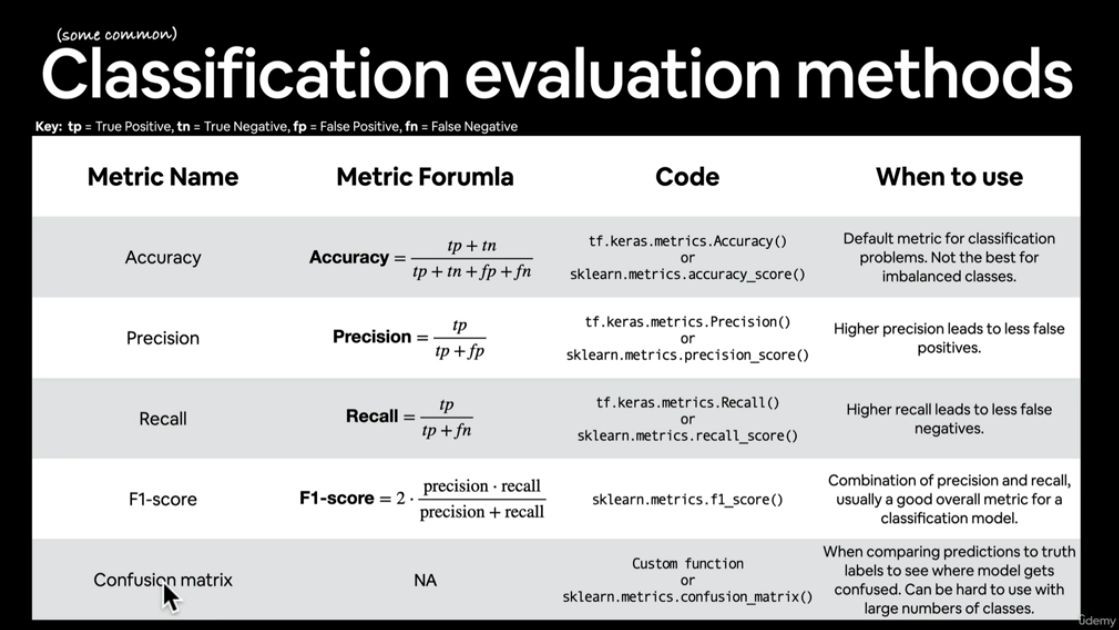![2024-01-27.png](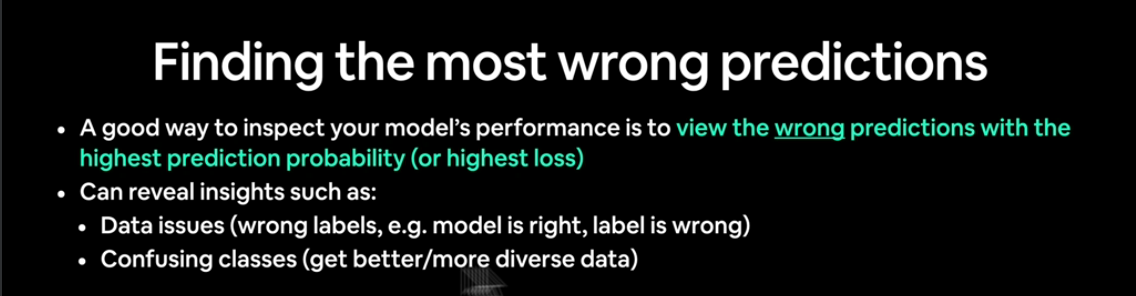![2024-01-27.png](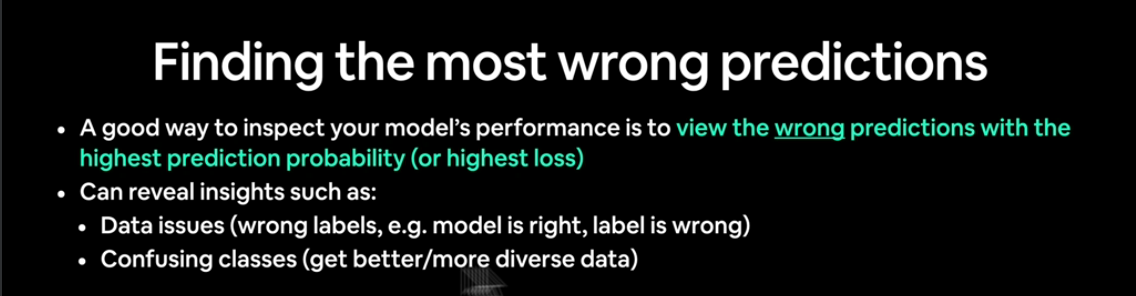![2024-01-27.png](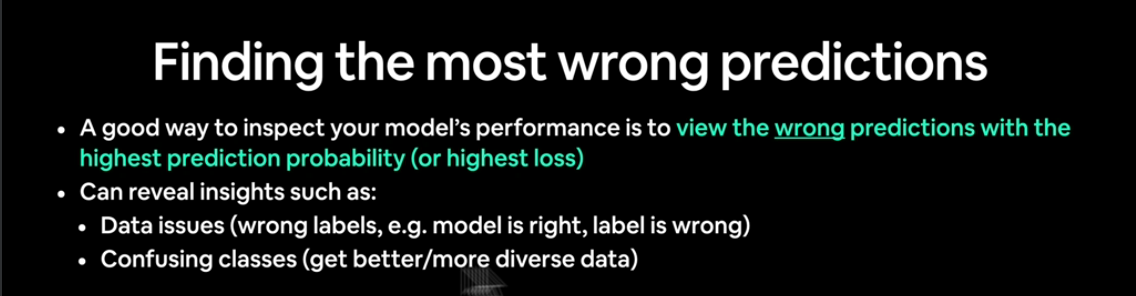![2024-01-27.png](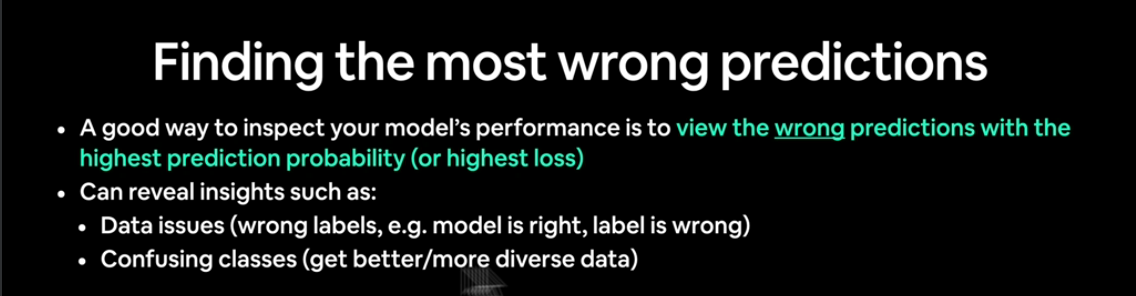![2024-01-27.png](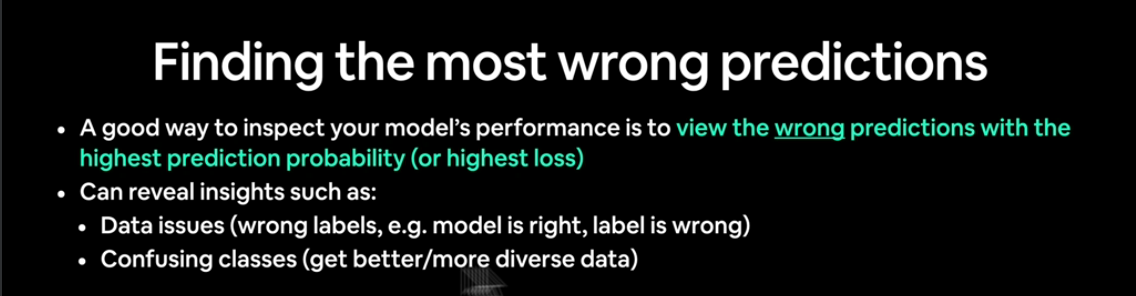![2021-06-06.png](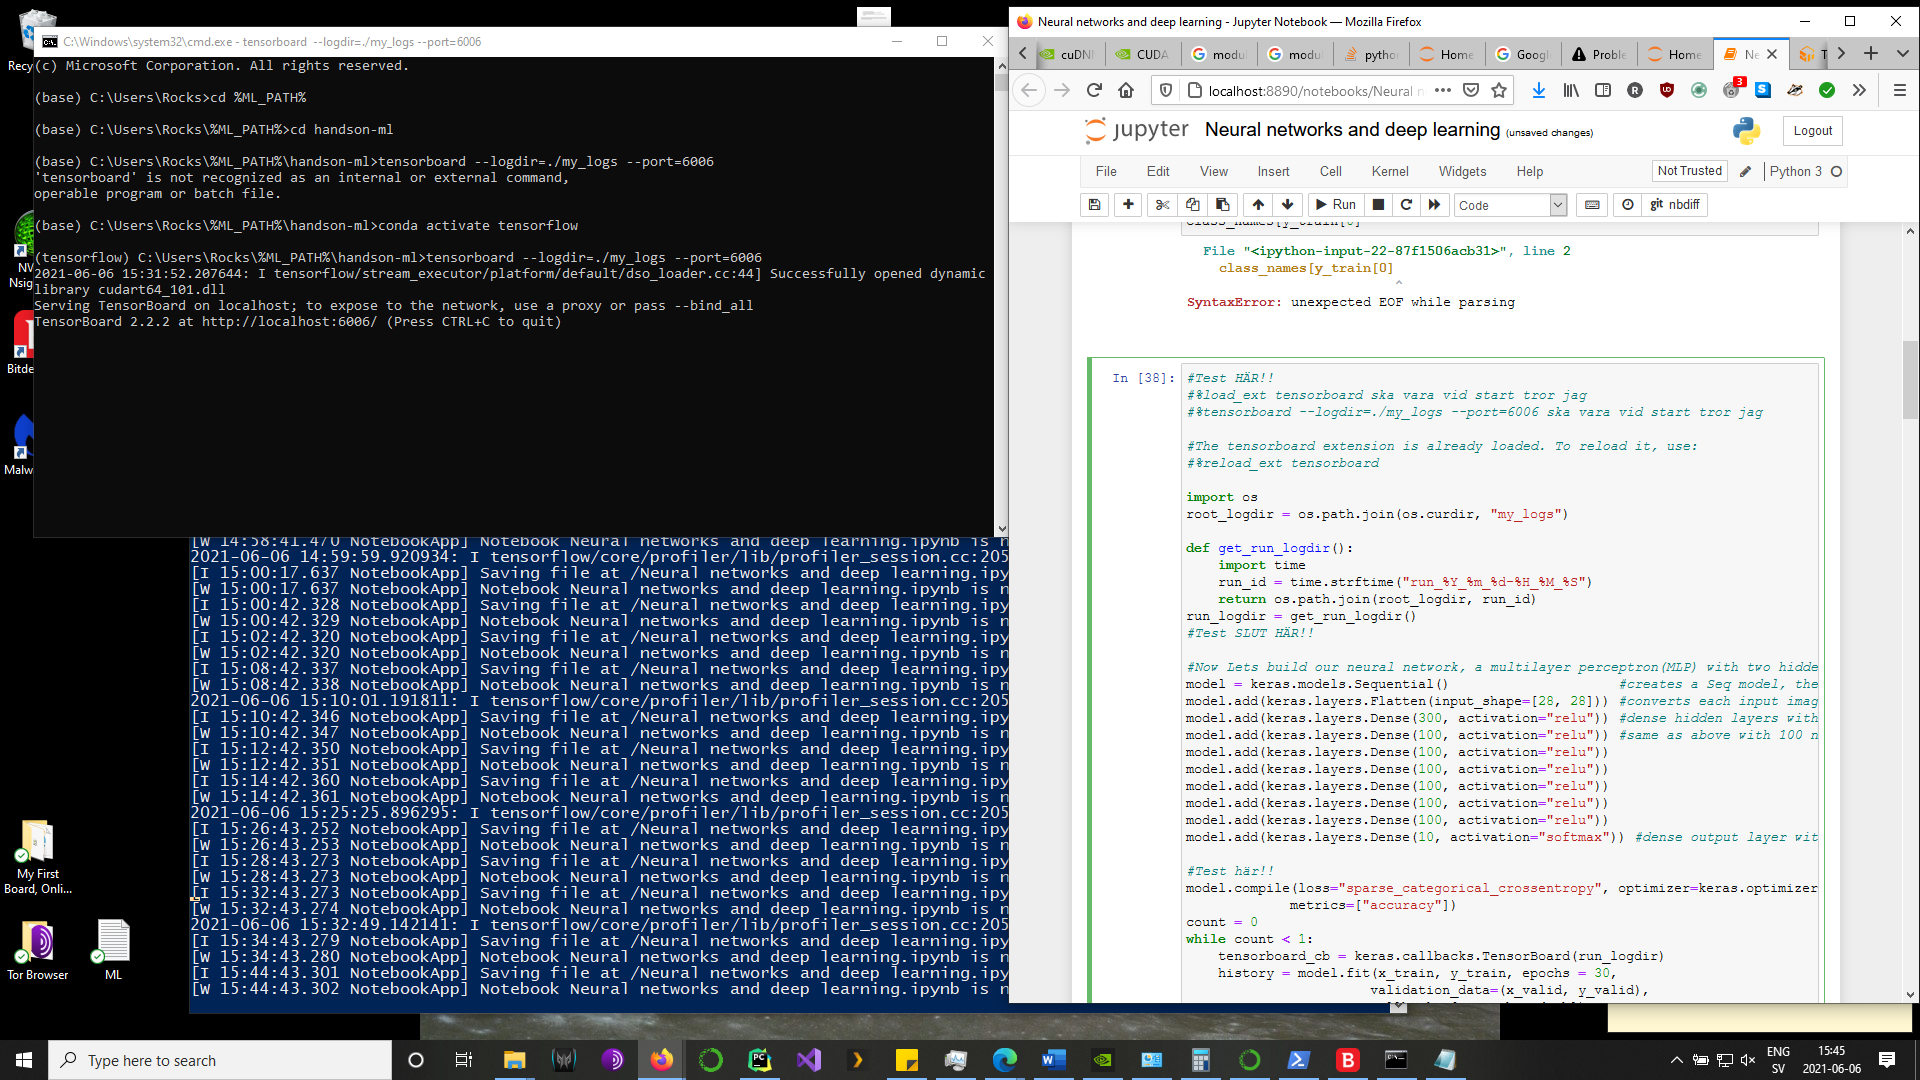![2024-01-27.png](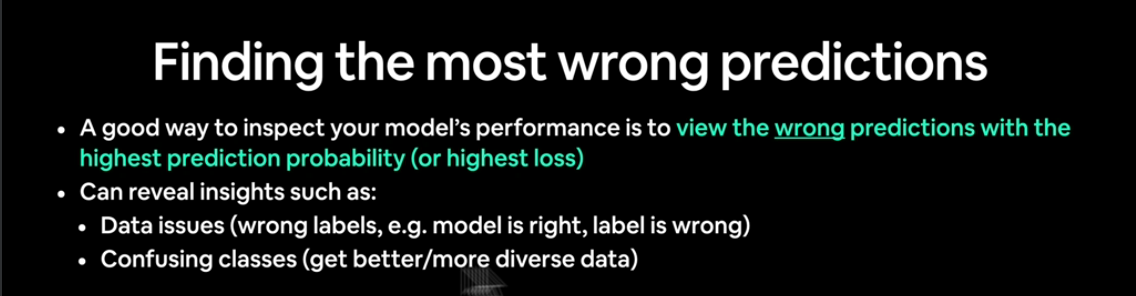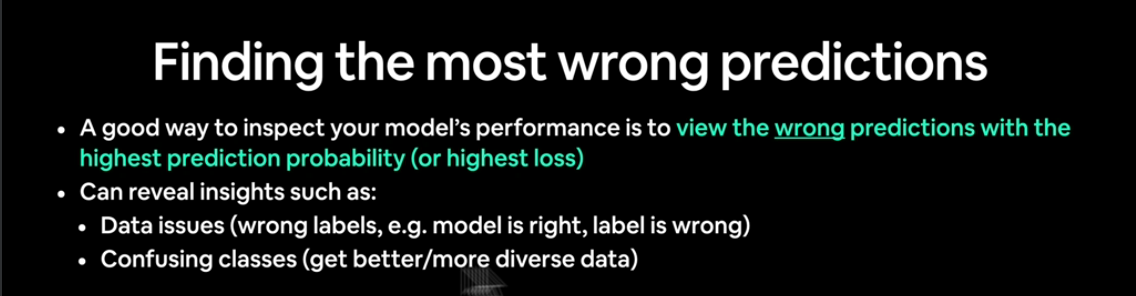))))))))

## Let's keep the evaluation going, time for classification report

Scikit-learn has a helpfuk function for acquiring many different classification metrics per class (e.g precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) , lets try that out.


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.30      0.13      0.18       250
           1       0.45      0.71      0.55       250
           2       0.43      0.78      0.56       250
           3       0.71      0.58      0.63       250
           4       0.65      0.38      0.48       250
           5       0.55      0.41      0.47       250
           6       0.77      0.70      0.73       250
           7       0.86      0.68      0.76       250
           8       0.22      0.62      0.32       250
           9       0.69      0.26      0.37       250
          10       0.40      0.48      0.44       250
          11       0.92      0.39      0.55       250
          12       0.61      0.64      0.62       250
          13       0.67      0.52      0.59       250
          14       0.71      0.52      0.60       250
          15       0.32      0.36      0.34       250
          16       0.55      0.62      0.58       250
          17       0.42    

The nubers above give a great class-by-class evaluation of our model's predictions but with so many classses, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [45]:
# Get a dictonary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3018867924528302,
  'recall': 0.128,
  'f1-score': 0.17977528089887643,
  'support': 250},
 '1': {'precision': 0.45153061224489793,
  'recall': 0.708,
  'f1-score': 0.5514018691588785,
  'support': 250},
 '2': {'precision': 0.4298245614035088,
  'recall': 0.784,
  'f1-score': 0.5552407932011332,
  'support': 250},
 '3': {'precision': 0.7058823529411765,
  'recall': 0.576,
  'f1-score': 0.6343612334801761,
  'support': 250},
 '4': {'precision': 0.6506849315068494,
  'recall': 0.38,
  'f1-score': 0.4797979797979798,
  'support': 250},
 '5': {'precision': 0.5508021390374331,
  'recall': 0.412,
  'f1-score': 0.471395881006865,
  'support': 250},
 '6': {'precision': 0.7699115044247787,
  'recall': 0.696,
  'f1-score': 0.7310924369747899,
  'support': 250},
 '7': {'precision': 0.8636363636363636,
  'recall': 0.684,
  'f1-score': 0.7633928571428572,
  'support': 250},
 '8': {'precision': 0.21678321678321677,
  'recall': 0.62,
  'f1-score': 0.3212435233160622,
  'support'

In [46]:
# Use the class_names with th dict to see classes
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores..

In [47]:
# Create an empty dict
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dict
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.17977528089887643,
 'baby_back_ribs': 0.5514018691588785,
 'baklava': 0.5552407932011332,
 'beef_carpaccio': 0.6343612334801761,
 'beef_tartare': 0.4797979797979798,
 'beet_salad': 0.471395881006865,
 'beignets': 0.7310924369747899,
 'bibimbap': 0.7633928571428572,
 'bread_pudding': 0.3212435233160622,
 'breakfast_burrito': 0.37317784256559766,
 'bruschetta': 0.4355716878402904,
 'caesar_salad': 0.550561797752809,
 'cannoli': 0.624031007751938,
 'caprese_salad': 0.5855855855855856,
 'carrot_cake': 0.6022988505747128,
 'ceviche': 0.3377110694183865,
 'cheese_plate': 0.5831775700934579,
 'cheesecake': 0.3991683991683992,
 'chicken_curry': 0.45433255269320844,
 'chicken_quesadilla': 0.6211180124223602,
 'chicken_wings': 0.7214428857715431,
 'chocolate_cake': 0.5068965517241378,
 'chocolate_mousse': 0.3598200899550225,
 'churros': 0.6924731182795699,
 'clam_chowder': 0.7379454926624739,
 'club_sandwich': 0.6739130434782609,
 'crab_cakes': 0.3735955056179776,
 'creme_brulee'

In [48]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [49]:
f1_scores

class_names  f1-score
33                  edamame  0.951456
63                 macarons  0.913319
32                dumplings  0.878661
45            frozen_yogurt  0.842536
69                  oysters  0.827309
..                      ...       ...
59                  lasagna  0.286645
49  grilled_cheese_sandwich  0.280899
84                  risotto  0.273418
66                   nachos  0.241379
0                 apple_pie  0.179775

[101 rows x 2 columns]

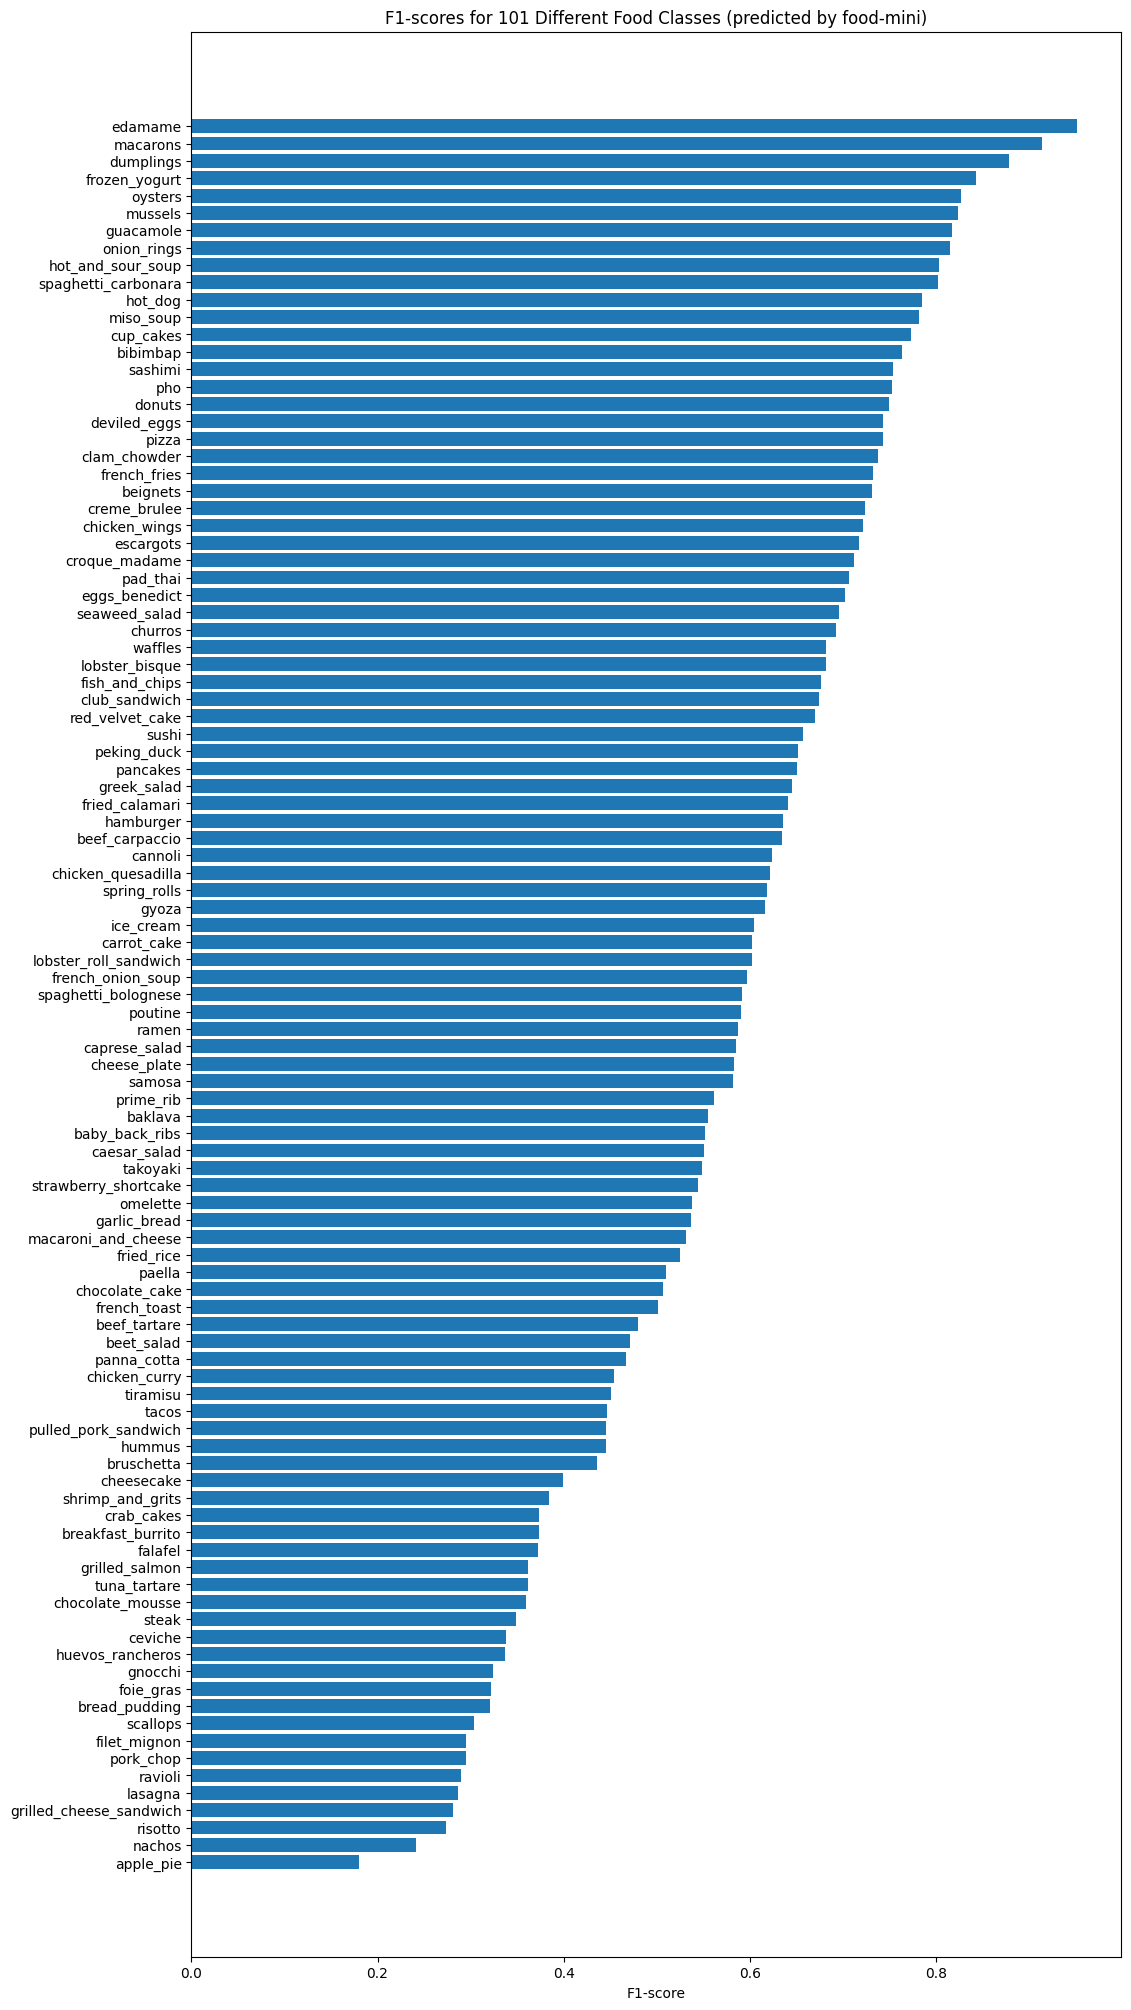

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # Get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by food-mini)")
ax.invert_yaxis(); # Reverse the order of our plot

## Challenge, use [this](https://matplotlib.org/2.0.2/examples/api/barchart_demo.html) to create the bars

In [51]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

In [52]:
autolabel(scores)

# Visa diagrammet
plt.show(scores)

## Visualizing predictions on test images

Now, this is the real test,how does the model go on food images not even in our test dataset (my own images will be seen later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file() (io stands for input/output)
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image toget all our pixel values between 0 & 1 (if necessary)


In [53]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3*)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into a tensor
  img= tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # Don't need to rescale images for EfficientNet models in TensorFlow

Now we've got a funnction to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
* Load a few random images from the test dataset
* Make predictions on the loaded images
* Plot the original image(s) along with the model's predictions, prediction probability and truth label

1/1 [==============================] - 0s 23ms/step


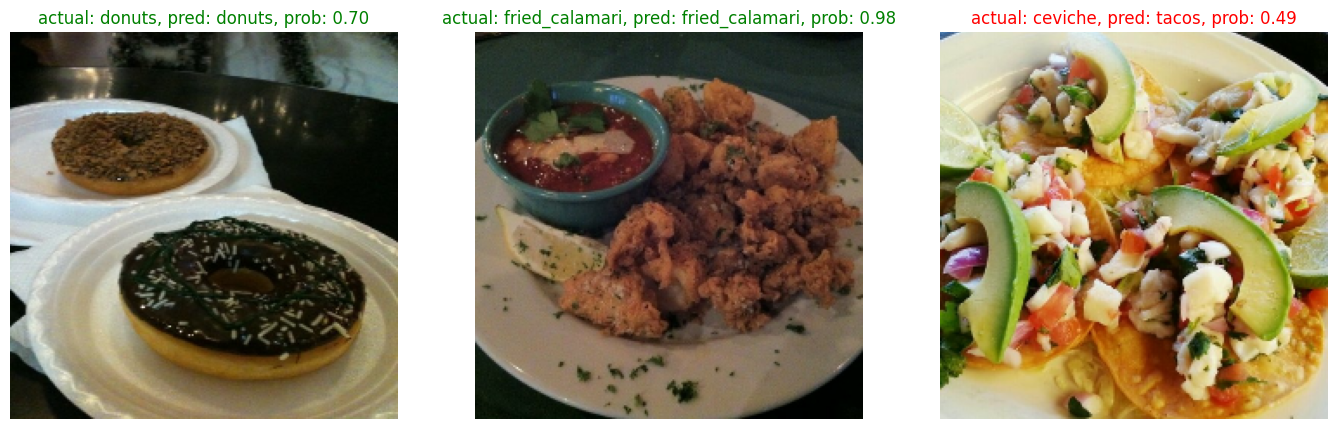

In [54]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  #print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  #print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # Get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # Get highest prediction probability index and match it to class_names list
  #print(pred_prob)
  #print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # If predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions
insert pic


To find out where our model is most wrong, let's write some code to find out the following:
* Get all of the image file paths in the test dataset using [list_files()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#used-in-the-notebooks) method
* Ceate a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model),max prediction probabilities, prediction class names, ground truth class names.
* Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
* Sort the DataFrame based on wrong predictions (have he highest probability predictions at top).
* Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [57]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [61]:
# 2. Create a DataFrame of differnet parameters for each of the test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # Get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0       2   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      38   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100      47   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.810909        apple_pie               baklava  
1       0.966030        apple_pie             apple_pie  
2       0.440208        apple_pie             apple_pie  
3       0.640904        apple_pie        fish_and_chips  
4       0.809345        apple_pie         bread_pudding  
...          ...              ...                   ...  
25245   0.999548          waffles               waffles  
25246   0.819582          waffles          cheese_plate  
25247   0.327133          waffles               gnocchi  
25248   0.252989          waffles  strawberry_shortcake  
25249   0.940858          waffles               waffles  

[25250 rows x 6 columns]

In [59]:
[class_names[i] for i in y_labels[:10]]

['apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie']